In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

from torch.optim import lr_scheduler
batch_size=16
learning_rate=0.002
num_epoch=1 #하나만 돌려서 성능비교해보기

In [3]:
cifar_train=dset.CIFAR10("CIFAR10/",train=True,transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))
                                    ]),
                                    target_transform=None,download=True)
cifar_test=dset.CIFAR10("CIFAR10/",train=False,transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))
                                    ]),
                                    target_transform=None,download=True)

Files already downloaded and verified
Files already downloaded and verified


cifar_train 길이: 50000
cifar_test 길이: 10000
image data형태: torch.Size([3, 32, 32])
label: 9


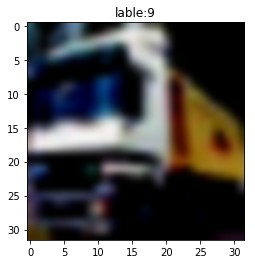

In [4]:
print "cifar_train 길이:",len(cifar_train)
print "cifar_test 길이:",len(cifar_test)

#데이터 하나형태
image,label=cifar_train.__getitem__(1)#1번쨰 데이터
print"image data형태:",image.size()
print"label:",label
#그리기
img=image.numpy()#image타입을 numpy로 변환(3,32,32) rgb,width,height

#(3,32,32)->(32,32,3)
r,g,b=img[0,:,:],img[1,:,:],img[2,:,:]
#img=img.reshape(img.shape[1],img.shape[2],img.shape[0])
img2=np.zeros((img.shape[1],img.shape[2],img.shape[0]))
img2[:,:,0],img2[:,:,1],img2[:,:,2]=r,g,b

plt.title("lable:%d"%label)
plt.imshow(img2,interpolation='bicubic')
plt.show()

In [5]:
def ComputeAccr(dloader,imodel):
    correct=0
    total=0
    
    for j,[imgs,labels] in enumerate(dloader):#batchsize만큼
        img=Variable(imgs,volatile=True)#.cuba()#x
        #label=Variable(labels) #y
        label=Variable(labels)#.cuba()
        #cuba() Gpu에 로드되기위함 만약 cpu로 설정되어있다면 에러남
        
        output=imodel(img)#정방향 전파
        _,output_index=torch.max(output,1) 
        
        total+=label.size(0)
        correct+=(output_index==label).sum().float()
    print("Accuracy of Test data:{}" .format(100*correct/total))


In [6]:
#데이터 로드함수
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:],
                                         batch_size=batch_size,shuffle=True,num_workers=2,drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)
#모델선언
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(3,16,3,padding=1),
            nn.ReLU(),
            #nn.Dropout2d(0.2), #(2)dropout
            #nn.BatchNorm2d(16),    #(8)batch normalization
            nn.Conv2d(16,32,3,padding=1),
            nn.ReLU(),
            #nn.Dropout2d(0.2), #(2)dropout
            #nn.BatchNorm2d(32),    #(16)batch normalization
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            #nn.Dropout2d(0.2),      #(2)dropout
            #nn.BatchNorm2d(64),    #(64)batch normalization     
            nn.MaxPool2d(2,2)
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*8*8,100),
            nn.ReLU(),
            #nn.Dropout2d(0.2),      #(2)dropout
            #nn.BatchNorm1d(100),    #(64)batch normalization     
            nn.Linear(100,10)
        )
    def forward(self,x):
        out=self.layer(x)
        out=out.view(batch_size,-1)
        out=self.fc_layer(out)
        
        return out
model=CNN()

In [7]:
loss_func=nn.CrossEntropyLoss()#loss함수
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)#optimizer선택

for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x=Variable(image)
        y_=Variable(label)
        
        optimizer.zero_grad()
        output=model.forward(x)
        loss=loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        if j%1000==0:
            print(j,loss)

(0, tensor(2.2893, grad_fn=<NllLossBackward>))
(1000, tensor(2.3184, grad_fn=<NllLossBackward>))
(2000, tensor(2.1371, grad_fn=<NllLossBackward>))
(3000, tensor(2.0568, grad_fn=<NllLossBackward>))


In [8]:
ComputeAccr(test_loader,model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test data:29.8400001526
